# Lesson 1: Image Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import pathlib

In [3]:
bs = 64

## Load dataset

This notebook will classify the images in `/home/jupyter/datasets/bug_bites/`.

To run with a different dataset, simply change the path.

In [4]:
path = pathlib.PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms')
path.ls()

[PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Suillus'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Entoloma'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Amanita'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Agaricus'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Boletus'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Lactarius'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Cortinarius'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Hygrocybe'),
 PosixPath('/home/jupyter/datasets/mushrooms/Mushrooms/Russula')]

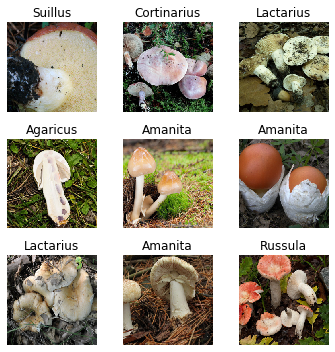

In [5]:
data = ImageDataBunch.from_folder(path,
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  valid_pct=0.2,
                                  bs=bs).normalize(imagenet_stats)

data.classes
data.show_batch(rows=3, figsize=(5,5))

## Training

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
# to avoid "OSError: image file is truncated (95 bytes not processed)"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,0.940907,0.803492,0.274963,00:46
1,0.924456,0.702286,0.245156,00:45
2,0.773264,0.651614,0.234724,00:46
3,0.630344,0.617242,0.204173,00:46


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

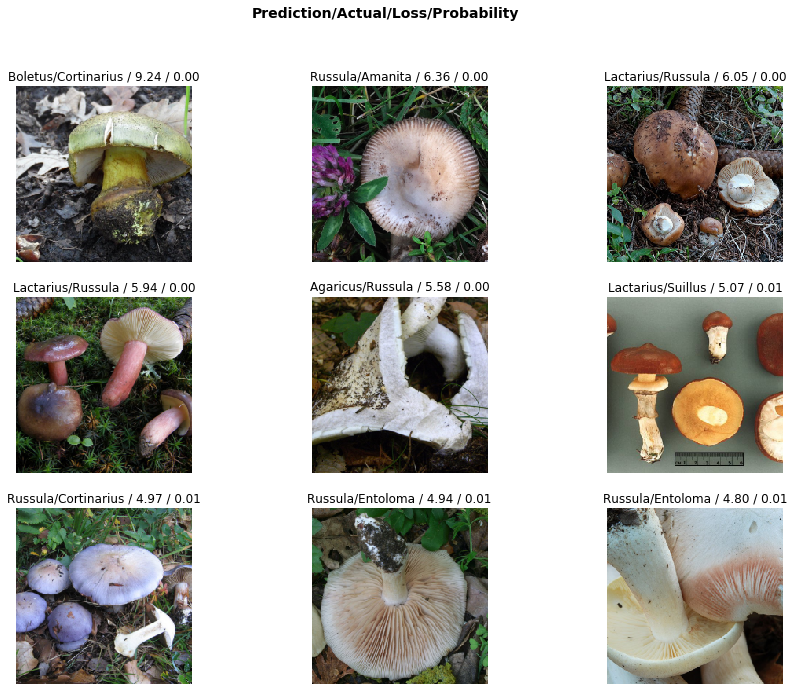

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

In [12]:
doc(interp.plot_top_losses)

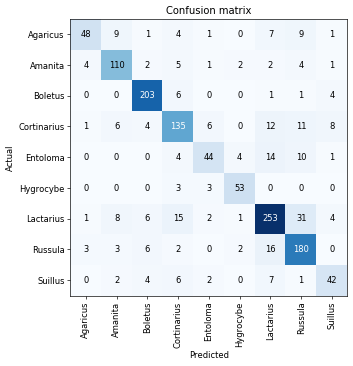

In [13]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [15]:
interp.most_confused(min_val=4)

[('Lactarius', 'Russula', 31),
 ('Russula', 'Lactarius', 16),
 ('Lactarius', 'Cortinarius', 15),
 ('Entoloma', 'Lactarius', 14),
 ('Cortinarius', 'Lactarius', 12),
 ('Cortinarius', 'Russula', 11),
 ('Entoloma', 'Russula', 10),
 ('Agaricus', 'Amanita', 9),
 ('Agaricus', 'Russula', 9),
 ('Cortinarius', 'Suillus', 8),
 ('Lactarius', 'Amanita', 8),
 ('Agaricus', 'Lactarius', 7),
 ('Suillus', 'Lactarius', 7),
 ('Boletus', 'Cortinarius', 6),
 ('Cortinarius', 'Amanita', 6),
 ('Cortinarius', 'Entoloma', 6),
 ('Lactarius', 'Boletus', 6),
 ('Russula', 'Boletus', 6),
 ('Suillus', 'Cortinarius', 6),
 ('Amanita', 'Cortinarius', 5),
 ('Agaricus', 'Cortinarius', 4),
 ('Amanita', 'Agaricus', 4),
 ('Amanita', 'Russula', 4),
 ('Boletus', 'Suillus', 4),
 ('Cortinarius', 'Boletus', 4),
 ('Entoloma', 'Cortinarius', 4),
 ('Entoloma', 'Hygrocybe', 4),
 ('Lactarius', 'Suillus', 4),
 ('Suillus', 'Boletus', 4)]

## Fine-tuning

In [16]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.768532,0.615206,0.212370,00:47


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96f21f3e60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96f21f3e60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/anacond

The error_rate was worse than that of our previously trained model, so let's reload it:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


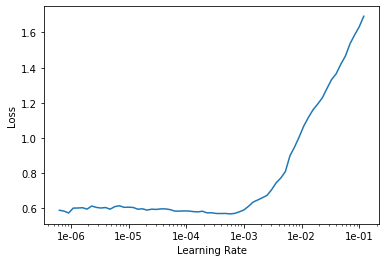

In [17]:
learn.load('stage-1')
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.513037,0.533368,0.181818,00:46
1,0.466827,0.463910,0.170641,00:46
2,0.351338,0.419423,0.154247,00:46
3,0.279283,0.407601,0.144560,00:46


In [20]:
learn.save('stage-2')

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.425830,1.482606,0.342772,00:50
1,0.535629,0.462574,0.163934,00:52
2,0.311738,0.373054,0.125931,00:52
